In [65]:
import pandas as pd
import numpy as np

In [66]:
# Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

dt = pd.read_csv('train.csv')
dt.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [67]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [68]:
# так как цель домашки не в фича-инжиниринге, принимаем самые простые решения. Столбцы, содержащие мало данных - выпиливаем
dt.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [69]:
dt.dropna(inplace=True)

In [70]:
dt = pd.get_dummies(dt)

In [71]:
msk = np.random.rand(len(dt)) < 0.2

In [72]:
holdout = dt[msk]
dt = dt[~msk]

In [73]:
# Построить случайный лес, вывести важность признаков
X = dt.drop('SalePrice', axis = 1)
Y = dt.SalePrice

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [76]:
# Так как фич очень много, оставим тоько самые важные
fi = pd.DataFrame(X.columns, model.feature_importances_).reset_index()
fi.columns = ['imp', 'name']
fi_imp = fi.loc[fi['imp'] > 0.01]
fi_imp

,imp,name
3,0.018274,LotArea
4,0.647819,OverallQual
9,0.032652,BsmtFinSF1
12,0.019255,TotalBsmtSF
13,0.015330,1stFlrSF
14,0.029606,2ndFlrSF
16,0.066848,GrLivArea


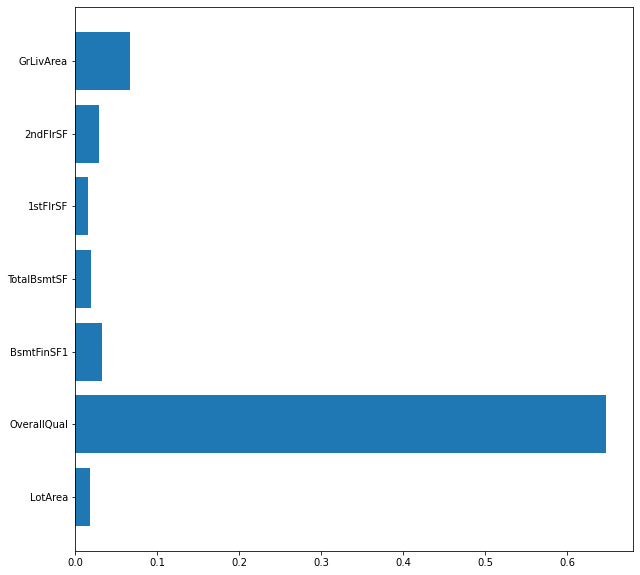

In [77]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
plt.barh(np.arange(len(fi_imp.imp)), fi_imp.imp)
plt.yticks(np.arange(len(fi_imp.name)),fi_imp.name)
plt.show()

In [78]:
# строим стекинг
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [79]:
rg = StackingRegressor(
    [
        ('en', ElasticNetCV()),
        ('dt', DecisionTreeRegressor(),
         'lr', LinearRegression())
    ],
DecisionTreeRegressor())

In [80]:
rg.fit(X_train, y_train)
pred2 = rg.predict(X_test)

In [81]:
from sklearn.model_selection import cross_val_score

In [82]:
Xhold = dt.drop('SalePrice', axis = 1)
Yhold = dt.SalePrice

In [83]:
# выведем оценку качества для простого случайного леса
np.mean(cross_val_score(model, Xhold, Yhold, cv=10))

0.837897159708157

In [84]:
# выведем оценку качества для стекинга
np.mean(cross_val_score(rg, Xhold, Yhold, cv=10))

0.5554247162296504

In [ ]:
''''в данном конкретном случае вышло, что случайный лес обучился значительно лучше, 
чем стекинг, включающий его как одну из моделей''''